<a href="https://colab.research.google.com/github/Sunil2201/micrograd-from-scratch/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3)

20

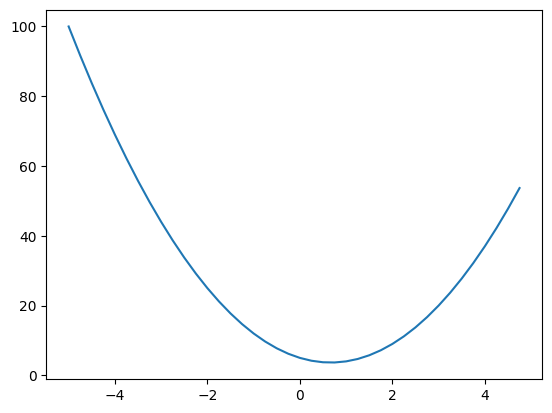

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): #-self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'
L
# The above expression is ideally (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:  # Changed from v.prev to v._prev
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular (record) node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

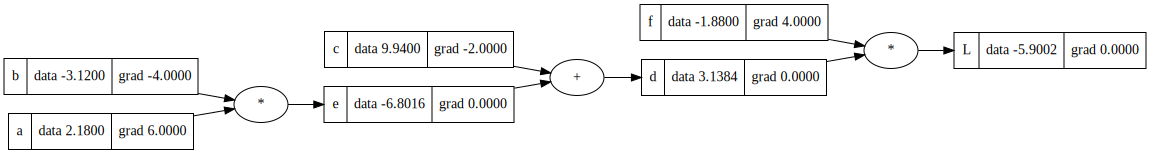

In [ ]:
draw_dot(L)

In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10, label='c')
  e = a*b; e.label='e'
  d = e + c; d.label='d'
  f = Value(-2.0, label='f')
  L = d*f; L.label='L'
  L2 = L.data + h

  print((L2-L1) / h)


lol()

1.000000000000334


In [ ]:
L.grad = 1.0

In [ ]:
# L = d*f
# dL/dd = ? = f
# (f(x+h) - f(x))/h
# ((d+h)*f - d*f)/h
# hf/h
# f

In [ ]:
f.grad=4
d.grad=-2

In [ ]:
# dd/dc = 1.0
# dd/de = 1.0

# d = c + e - so the derivatives of constants is 1

# WANT:
# dL/dc = (dL / dd) * (dd / dc) -> By the rule of chaining

# KNOW:
# dL/dd
# dd/dc

In [ ]:
c.grad = -2.0
e.grad = -2.0

In [ ]:
# dL / de = -2.0

# e = a * b
# de / da = ? = b

# Derivation
# (f(x+h) - f(x)) / h
# ((a+h)*b - a*b) / h
# bh/h
# b

# dL / da = (dL / de) * (de / da) -> by rule of chaining
# dL / da = -2.0 * -3.0
# dL / da = 6

# dL / db = (dL / de) * (de / db) -> by rule of chaining
# dL / da = -2.0 * 2.0
# dL / da = -4.0

In [ ]:
a.grad = 6.0
b.grad = -4.0

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

print(L.data)

-5.900192000000001


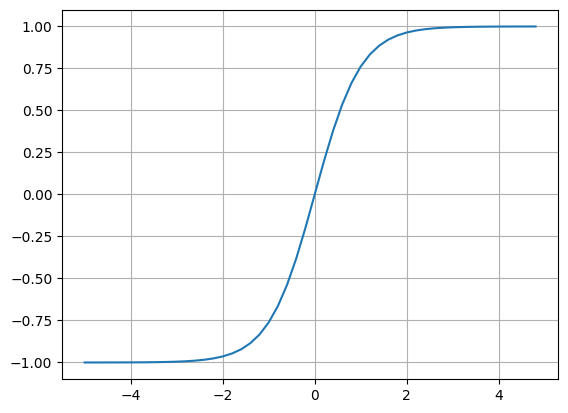

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid();

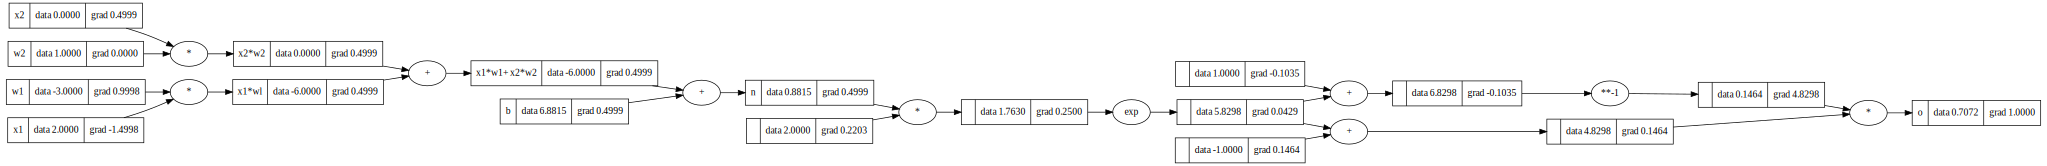

In [ ]:
#inputs x1,x2
x1 = Value (2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value (1.0, label='w2')
#bias of the neuron
b = Value(6.8814873984949, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*wl'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1+ x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----X-----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----X-----
o.label = 'o'
o.backward()
draw_dot(o)

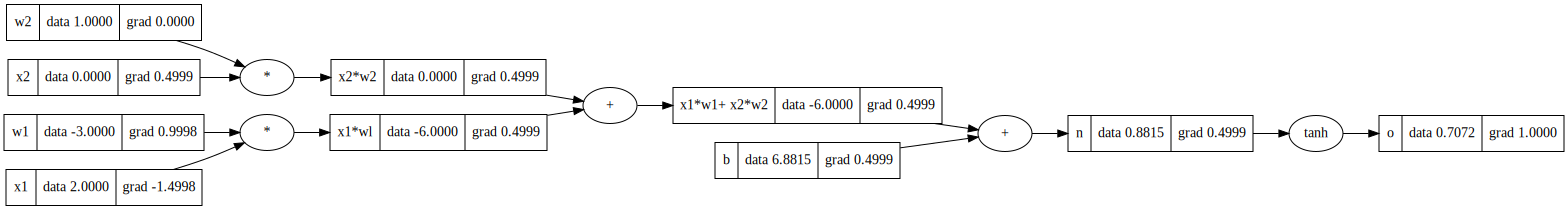

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

In [ ]:
o.backward()

In [ ]:
# o = tanh(n)
# do / dn = 1 - o ** 2

In [ ]:
o.grad = 1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
# 1 - o.data ** 2
n.grad = 0.5

In [ ]:
x1w1x2w2.grad = n.grad
b.grad = n.grad

In [ ]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [ ]:
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

In [ ]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

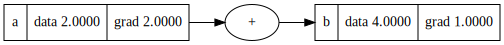

In [ ]:
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

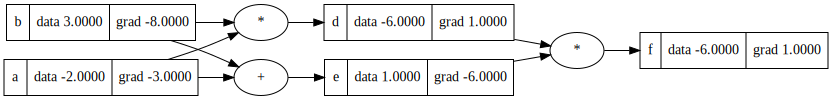

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

In [ ]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [ ]:
a = Value(2.0)
2 * a

Value(data=4.0)

In [ ]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [ ]:
# Rewriting Division

# a / b
# a * (1 / b)
# a * (b ** -1)

# Thats why we are gonna implement x**k -> where k is a constant

In [ ]:
a = Value(2.0)
b = Value(4.0)

x = a / b
x

Value(data=0.5)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor ([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor ([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9611346519450259)

In [ ]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9611346519450259),
 Value(data=0.8834146800569161),
 Value(data=0.9632558184773429),
 Value(data=0.9403192417025545)]

In [ ]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))
loss

Value(data=7.40669657402943)

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

1.5730248470986647

In [ ]:
n.layers[0].neurons[0].w[0].data

0.11094358884872584

In [ ]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.0006276661342400364
1 0.0006261313199848709
2 0.0006246037768489823
3 0.0006230834538914708
4 0.0006215703006430686
5 0.0006200642671007352
6 0.0006185653037223275
7 0.0006170733614212572
8 0.0006155883915613744
9 0.0006141103459517651
10 0.0006126391768417219
11 0.0006111748369157594
12 0.0006097172792886522
13 0.0006082664575006032
14 0.0006068223255124559
15 0.0006053848377009152
16 0.000603953948853957
17 0.0006025296141661633
18 0.0006011117892341966
19 0.0005997004300523453


In [ ]:
ypred

[Value(data=0.9907579012620239),
 Value(data=-0.9861046759896926),
 Value(data=-0.9895716831099041),
 Value(data=0.9854241906414031)]

In [ ]:
for p in n.parameters():
  print(p)

Value(data=0.11094358884872584)
Value(data=0.785996347348096)
Value(data=-0.16645870519011402)
Value(data=-0.9478232758688551)
Value(data=-0.7994843494757361)
Value(data=-0.1538925858803167)
Value(data=0.3617458078127872)
Value(data=-0.8222775681318678)
Value(data=-0.6112299707058962)
Value(data=0.24969006686667033)
Value(data=-0.8112245918671475)
Value(data=0.6804948556573139)
Value(data=-0.7508108503110102)
Value(data=0.13759591997160805)
Value(data=1.1994691564368576)
Value(data=0.10722138764638654)
Value(data=-0.340508906928593)
Value(data=0.27473732450487975)
Value(data=1.0729355308379405)
Value(data=-0.5709499746774314)
Value(data=-0.16437484530800725)
Value(data=-0.3927810489249698)
Value(data=-0.674092222072077)
Value(data=0.2521659637931429)
Value(data=0.13112215448887055)
Value(data=0.1949627837956836)
Value(data=-0.9274445635583765)
Value(data=-0.302704256351691)
Value(data=-0.9747214913146587)
Value(data=0.7432050660590457)
Value(data=0.00814253081329732)
Value(data=-0.7959

**UNDERSTANDING NEURONS**
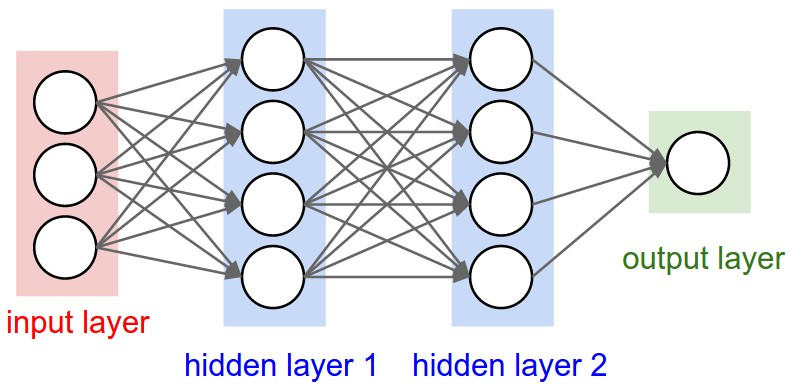

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9983953767783861)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.7156853226588565),
 Value(data=0.978567755989019),
 Value(data=-0.9845465958028349)]

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts  #[3, 4, 4, 1] - This represents the architecture: 3 inputs → 4 neurons → 4 neurons → 1 output.
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    #Creates the layers by connecting consecutive sizes:
      #Layer(sz[0], sz[1]) = Layer(3, 4) - takes 3 inputs, outputs 4 values
      #Layer(sz[1], sz[2]) = Layer(4, 4) - takes 4 inputs, outputs 4 values
      #Layer(sz[2], sz[3]) = Layer(4, 1) - takes 4 inputs, outputs 1 value

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  #This is the key part! It passes the input through each layer sequentially. The output of one layer becomes the input to the next:
   #Start: x = [2.0, 3.0, -1.0] (3 values)
   #After layer 1: x = [v1, v2, v3, v4] (4 values)
   #After layer 2: x = [v5, v6, v7, v8] (4 values)
   #After layer 3: x = v9 (1 value)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7276729815595875)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.029981667635799406),
 Value(data=-0.03716030549155599),
 Value(data=0.06506880164735464),
 Value(data=0.11679736485568994)]